In [1]:
import cv2
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline


(1) Preprocessing: Detect face and eyes
When we look at any image, most of the time we identify a person using a face. An image might contain multiple faces, also the face can be obstructed and not clear. The first step in our pre-processing pipeline is to detect faces from an image. Once face is detected, we will detect eyes, if two eyes are detected then only we keep that image otherwise discard it.</h4>
Now how do you detect face and eyes?

We will use haar cascade from opencv for this. Here is an article on this: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html?highlight=haar


In [2]:
img = cv2.imread('./test_images/https___images.ladepeche.fr_api_v1_images_view_616d247a3e4546697c3954c3_large_image.jpg_v_1.jpg')
img.shape

(500, 885, 3)

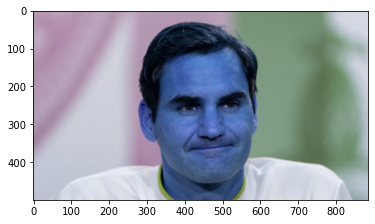

In [3]:
plt.imshow(img)

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(500, 885)

In [5]:
gray
# the gray values are all numbers from 0 to 255

array([[158, 159, 160, ..., 220, 220, 220],
       [159, 159, 160, ..., 221, 221, 221],
       [159, 159, 160, ..., 220, 221, 221],
       ...,
       [193, 194, 196, ..., 178, 178, 178],
       [193, 194, 196, ..., 177, 177, 177],
       [193, 194, 196, ..., 176, 176, 176]], dtype=uint8)

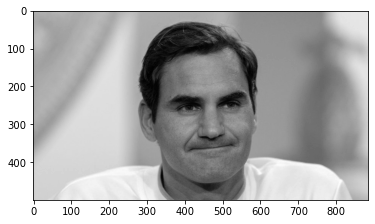

In [6]:
plt.imshow(gray, cmap='gray')

In [7]:
face_cascade = cv2.CascadeClassifier('./opencv/data/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/data/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[308, 124, 318, 318]])

In [8]:
# the 4 values in up are x , y , width & height
(x,y,w,h) = faces[0]
x,y,w,h

(308, 124, 318, 318)

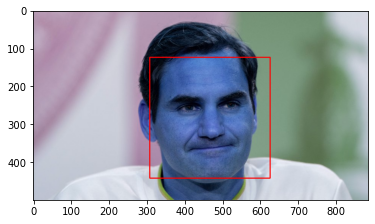

In [9]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

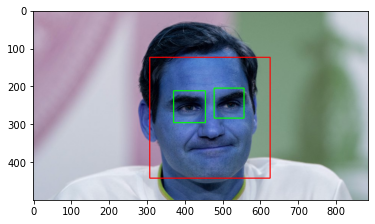

In [10]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

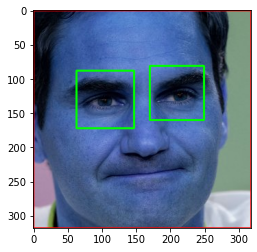

In [11]:
plt.imshow(roi_color, cmap='gray')
#roi stands for region of interest

Preprocessing: Load image, detect face. If eyes >=2, then save and crop the face region
Lets write a python function that can take input image and returns cropped image (if face and eyes >=2 are detected)


In [12]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    if(img is not None):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.3, 5)
        for (x,y,w,h) in faces:
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = img[y:y+h, x:x+w]
            eyes = eye_cascade.detectMultiScale(roi_gray)
            if len(eyes) >= 2:
                return roi_color   
    else:
        exit(1)

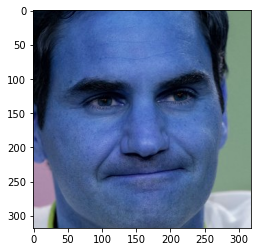

In [13]:
cropped_image = get_cropped_image_if_2_eyes('./test_images/https___images.ladepeche.fr_api_v1_images_view_616d247a3e4546697c3954c3_large_image.jpg_v_1.jpg')
plt.imshow(cropped_image)

In [14]:
path_to_data = "./dataset/"
path_to_cr_data = "./dataset/cropped/"

In [15]:
import os
img_dirs = []
# this boucle means it will go to all subdirectories within the path_to_data directory
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [16]:
img_dirs

['./dataset/cropped',
 './dataset/lionel messi',
 './dataset/maria sharapova',
 './dataset/roger federer',
 './dataset/serena williams',
 './dataset/virat kohli']

In [17]:
# if the cropped folder exists it will remove it and create a new fresh one
import shutil
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [18]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        new_entry = entry.path.replace("\\", "/")
        roi_color = get_cropped_image_if_2_eyes(new_entry)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
                
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

Generating cropped images in folder:  ./dataset/cropped/lionel messi
Generating cropped images in folder:  ./dataset/cropped/maria sharapova
Generating cropped images in folder:  ./dataset/cropped/roger federer
Generating cropped images in folder:  ./dataset/cropped/serena williams
Generating cropped images in folder:  ./dataset/cropped/virat kohli


### now we gonna do the wavelet transformation which allows us to extract the important features of our images


(3) Preprocessing: Use wavelet transform as a feature for traning our model
In wavelet transformed image, you can see edges clearly and that can give us clues on various facial features such as eyes, nose, lips etc


# Wavelet transform

In [19]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

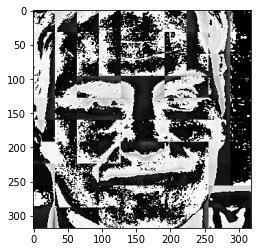

In [20]:
im_har = w2d(cropped_image,'db1',5)
plt.imshow(im_har, cmap='gray')

by creating this scary black and white image you're extracting the important features (facial one)
We process this way because when we used to have the colored image it's hard for the classifier to extract em u know    

it works this way : to detect federer face, he has a certain size of eyes, does he have a beard or not? how big his nose is ...

In [21]:
#Manually examine cropped folder and delete any unwanted images¶
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list
celebrity_file_names_dict

{'lionel messi': ['./dataset/cropped/lionel messi\\lionel messi1.png',
  './dataset/cropped/lionel messi\\lionel messi10.png',
  './dataset/cropped/lionel messi\\lionel messi12.png',
  './dataset/cropped/lionel messi\\lionel messi13.png',
  './dataset/cropped/lionel messi\\lionel messi14.png',
  './dataset/cropped/lionel messi\\lionel messi16.png',
  './dataset/cropped/lionel messi\\lionel messi17.png',
  './dataset/cropped/lionel messi\\lionel messi18.png',
  './dataset/cropped/lionel messi\\lionel messi2.png',
  './dataset/cropped/lionel messi\\lionel messi20.png',
  './dataset/cropped/lionel messi\\lionel messi21.png',
  './dataset/cropped/lionel messi\\lionel messi22.png',
  './dataset/cropped/lionel messi\\lionel messi23.png',
  './dataset/cropped/lionel messi\\lionel messi24.png',
  './dataset/cropped/lionel messi\\lionel messi25.png',
  './dataset/cropped/lionel messi\\lionel messi26.png',
  './dataset/cropped/lionel messi\\lionel messi27.png',
  './dataset/cropped/lionel messi\

In [22]:
class_dict = {}
count = 0
for celeb_name in celebrity_file_names_dict.keys():
    class_dict[celeb_name] = count
    count +=1
class_dict

{'lionel messi': 0,
 'maria sharapova': 1,
 'roger federer': 2,
 'serena williams': 3,
 'virat kohli': 4}

In [23]:
# Images in cropped folder can be used for model training. We will use these raw images along with 
# wavelet transformed images to train our classifier. Let's prepare X and y now
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])

In [24]:
len(X[0])
# 32*32*3 + 32*32*1 ( x, y, rgb ) + (x, y, gray=1)

4096

In [25]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(255, 4096)

### We finished Data cleaning, so Lets start training our model

we will use SVM with rbf kernel tuned with heuristic finetuning

In [26]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# we randomly choose the param for svc, we'll fine tune em later
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.734375

In [27]:
len(X_test)

64

In [28]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.71      0.92      0.80        13
           1       0.67      0.62      0.64        13
           2       1.00      0.33      0.50         6
           3       0.67      0.50      0.57        12
           4       0.79      0.95      0.86        20

    accuracy                           0.73        64
   macro avg       0.77      0.66      0.68        64
weighted avg       0.74      0.73      0.72        64




# Let's use GridSearch to try out different models with different paramets. Goal is to come up with best modle with best fine tuned parameters


In [29]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [31]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.806073,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.665182,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.801350,{'logisticregression__C': 5}


In [33]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=5, solver='liblinear'))])}

In [35]:
best_estimators['svm'].score(X_test,y_test)

0.8125

In [36]:
best_estimators['random_forest'].score(X_test,y_test)

0.578125

In [37]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.828125

In [38]:
best_clf = best_estimators['svm']

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))
cm

array([[13,  0,  0,  0,  0],
       [ 2,  9,  0,  2,  0],
       [ 0,  1,  4,  0,  1],
       [ 0,  3,  0,  8,  1],
       [ 1,  0,  0,  1, 18]], dtype=int64)

{'lionel messi': 0,
 'maria sharapova': 1,
 'roger federer': 2,
 'serena williams': 3,
 'virat kohli': 4}

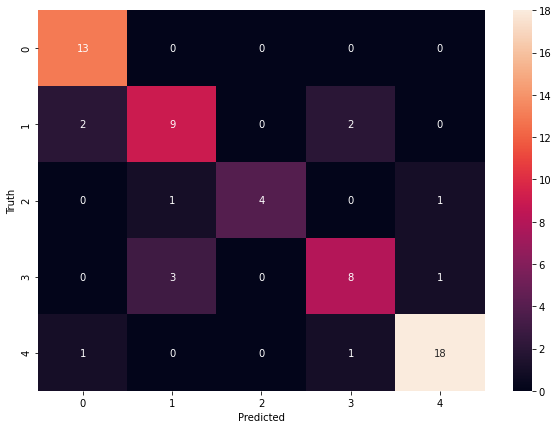

In [40]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

class_dict

In [41]:
#Save the trained model¶
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(best_clf, 'saved_model.pkl')

['saved_model.pkl']

In [42]:
#  Save class dictionary¶
import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))